# Using YData to synthesize sequential transactional data

## Context

Payments data is one of the most common types of transactional datasets, and for many business areas one of the most valuable. However, it is particularly sensitive and has complex underlying logic governing it, which makes it a perfect test bed for data quality assessment and synthetic data generation.

The dataset _“PaySim: A financial mobile money simulator for fraud detection”_ is a case study based on a real company that developed a mobile money implementation which provided mobile phone users the ability to transfer money between themselves using the phone as a sort of electronic wallet.

**Outline of this document**

- Ingesting and understanding a transactional financial dataset, including abidance by business logic
- Training a synthetic data generator over the dataset
- Generating a synthetic version of the dataset, integrating the aforementioned business logic
- Evaluating the statistical fidelity and coherence of the generated data

## Dataset: PaySim

PaySim simulates mobile money transactions based on a sample of real transactions (extracted from one month of financial logs from a mobile money service implemented in an African country). The original logs were provided by a multinational company, who is the provider of a mobile financial service currently running in more than 14 countries all around the world.

The PaySim version used is a custom one generated through the code on the [PaySim GitHub repository](https://github.com/EdgarLopezPhD/PaySim) and based on the paper [_PaySim: A financial mobile money simulator for fraud detection_](https://www.researchgate.net/publication/313138956_PAYSIM_A_FINANCIAL_MOBILE_MONEY_SIMULATOR_FOR_FRAUD_DETECTION).

This dataset version can be downloaded from **⚠️ TODO: add link to bucket with dataset**. 

### Loading the dataset

YData's platform is fully integrated - this means that any source of data created through the UI can be easily consumed within the Labs (via the [Platform SDK](https://github.com/ydataai/academy/blob/master/1%20-%20platform-sdk/ui-to-sdk-examples.ipynb)) for further exploration, leveraging the platform's built-in scalability. Alternatively, YData's [Connectors](https://github.com/ydataai/academy/tree/master/2%20-%20connectors) could also be used.

Below, the Platform SDK will be used. 

In [47]:
# Importing YData's packages
from ydata.platform.datasources import DataSources
from ydata.metadata import Metadata
from ydata.dataset import Dataset

# Creating a Dataset from the Data Source
datasource = DataSources.get(uid='1cb44d2e-6fd8-4f80-8411-cc34db893f88', namespace='47141dbf-73cf-45ed-9c4f-3ba32e5d1663')

dataset = datasource.read()

# Quickly previewing the Dataset
dataset.head()

,time,step,action,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,isUnauthorizedOverdraft
idx,,,,,,,,,,,,,
0,0,1,CASH_IN,229382.36,C3568019779,67.45,229449.80,M1836583048,0.0,0.0,0,0,0
1,1,1,CASH_IN,97393.77,C3961168589,49.69,97443.47,M4632515968,0.0,0.0,0,0,0
2,2,1,CASH_IN,232396.73,C8794318614,29.79,232426.53,M7113244499,0.0,0.0,0,0,0
3,3,1,CASH_IN,155631.49,C8239723447,23748.03,179379.52,M3688842852,0.0,0.0,0,0,0
4,4,1,CASH_IN,122791.96,C8050477779,29.66,122821.61,M4934014946,0.0,0.0,0,0,0


In [48]:
dataset = dataset.to_pandas()
dataset = dataset[:100000]
dataset = Dataset(dataset)

In [49]:
dataset.shape(lazy_eval=False)

(100000, 13)

In [50]:
dataset.value_counts(col='isUnauthorizedOverdraft')

{0: 98149, 1: 1851}

In [51]:
dataset.value_counts(col='isFraud')

{0: 99982, 1: 18}

In [52]:
dataset.value_counts(col='isFlaggedFraud')

{0: 100000}

In [53]:
dataset.uniques('action')

5

In [54]:
dataset.value_counts(col='isFlaggedFraud')

AttributeError: 'dict' object has no attribute 'compute'

From this quick peek at the dataset, we can identify several things:
    
- about 3.4 million transactions
- `time` is our sequential indicator (`step` represents an hour of transactions, `time` is a linear indicator of the transaction order)
- existing features: 
    - features describing the financial operation and its flow (`type`, `amount`, `nameOrig` and `nameDest`)
    - features keeping track of the balance of each financial entity (`oldbalanceDest`, `newbalanceDest`, `oldbalanceOrg`, `newbalanceOrig`) 
    - features related with fraud (`isFlaggedFraud`, automatically detected potential frauds and `isFraud`, the real assessment). 
- 5 types of financial transactions: `CASH_IN`, `CASH_OUT`, `PAYMENT`, `TRANSFER`, `DEBIT` (ordered by decreasing relative frequency)
- the existance of `isUnauthorizedOverdraft` events due to lack of funds (~1.67% of all transactions)
- the existence of fraudulent events in `isFraud`, with the dataset revealing a huge imbalance: only ~0.04% of all transactions were fraudulent
  - the `isFlaggedFraud` column is the result of a naive rule automatically flaggging transfers above 200k. This dataset in particular contains no such events. 

### Evaluating data quality

The automated profiling available on the platform heavily complements these insights above with univariante and multivariate profiling plus automatic detection of potential data quality issues. To access these data quality warnigs, useful to identify potential issues which must be solved prior to data synthesis, a `Metadata` object, holding information about the dataset, must be created.

In [55]:
# Creating a Metadata (where warnings can be reviewed) from the Dataset
metadata = Metadata(dataset)
print(metadata)

Metadata Summary 
 
Dataset type: TABULAR
Dataset attributes: 
Number of columns: 13
% of duplicate rows: 0
Target column: 

Column detail: 
                     Column    Data type Variable type
0                      time    numerical           int
1                      step  categorical           int
2                    action  categorical        string
3                    amount    numerical         float
4                  nameOrig  categorical        string
5            oldBalanceOrig    numerical         float
6            newBalanceOrig    numerical         float
7                  nameDest  categorical        string
8            oldBalanceDest  categorical         float
9            newBalanceDest  categorical         float
10                  isFraud  categorical           int
11           isFlaggedFraud  categorical           int
12  isUnauthorizedOverdraft  categorical           int

Warnings: 
                   Warning                                               Colu

This gives us additional information about the dataset: balances and amounts have highly skewed distributions, which suggests different transactions and client profiles. We also seem to have a large number of entities represented in this dataset, judging by the high cardinality warnings in our origin and destination entities.

On the other hand, we see no issues with high missingness of values or duplicates. For now, we will drop the `step` column, as we have seen it encodes similar information as the `time` and explictly selec

In [56]:
dataset.drop_columns(['step', 'isFlaggedFraud'], inplace=True)

In [57]:
dataset.columns

['time',
 'action',
 'amount',
 'nameOrig',
 'oldBalanceOrig',
 'newBalanceOrig',
 'nameDest',
 'oldBalanceDest',
 'newBalanceDest',
 'isFraud',
 'isUnauthorizedOverdraft']

### Validation of business rules 

A dataset not abiding by the expected business rules may silently go unnoticed through all the phases of a project and fail to deliver any business value when finally live. As such, it's important to validate these kind of constraints and business logic. 

YData's `ConstraintEngine` can be used for validation of several type of arbitrary row and column-wise constraints (per-entity, if required). 

#### Which business rules and constraints does this dataset have?

Stemming from its transactional-financial nature and given the [extra context available on Kaggle](https://www.kaggle.com/datasets/ealaxi/paysim1) and in the original paper, some implicit and explicit business rules can be derived for this dataset:
    
- There are 3 different types of entities: 
    - _Banks_, which are always destination entities and whose balance is always 0
    - _Customers_, which can be either origin or destination entities
    - _Merchants_, which are always destination entities
- Rejected overdraft operations (`isUnauthorizedOverdraft==1`), which can happen for all transaction types apart from `CASH_IN`, do not go through - the balances of both the origin and destination entity as kept. 
- Fraudulent events are an _a posteriori_ label, so all transactions marked as fraudulent (`isFraud == 1`) go through normally. 
- The `amount` column should only assume positive values (as the signal of the transaction depends on the `action`).
- For every transaction and throughout time, the state of each entity (its balance) should be coherent with its interaction with other entities. This depends on the type of transaction: 
    - `CASH_IN`: always from _Customer_ to _Merchant_, with the origin balance increasing and the destination balance staying the same. 
    - `CASH_OUT`: always from _Customer_ to _Merchant_, with the origin balance decreasing and the destination balance staying the same. 
    - `PAYMENT`: always from _Customer_ to _Merchant_, with the origin balance decreasing and the destination balance increasing.
    - `TRANSFER`: always from _Customer_ to _Customer_, with the origin balance decreasing and the destination balance increasing. 
    - `DEBIT`: always from _Customer_ to _Bank_, with the origin balance decreasing and the destination balance staying the same (0, as it is a _Bank_)
    
Additionally, it's possible that the starting balances of some entities (_Customers_ or _Merchants_) are negative. YData's constraints engine allows us to express all this. 

**⚠️ TODO**: Check if we want to validate all constraints. Which ones should use the `entity` argument? 

In [28]:
from ydata.constraints.engine import ConstraintEngine
from ydata.constraints.constraint import GreaterThan, Positive, CustomConstraint

# Create the custom constrains for the dataset
def validate_origin_entities(df):
    pass

def validate_destination_entities(df):
    pass

def validate_overdraft_behaviour(df): 
    pass

def validate_positive_amount(df):
    pass # not needed

def validate_cash_in_interaction(df):
    pass

def validate_cash_out_interaction(df):
    pass

def validate_payment_interaction(df):
    pass

def validate_transfer_interaction(df):
    pass

def validate_debit_interaction(df):
    pass

def validate_entity_balances(df):
    pass

# Validate coherence in balance of the origin entity during the transaction 
def check_originBalance(df):
    # How can we add this type of logic to deal with the associated signs? Can we maybe do an apply instead prior the validations?
    # balance(t) is in newBalanceOrig; balance(t-1) is in oldBalanceOrig
    
    action_mapping = {'DEBIT': -1, 'TRANSFER': -1, 'CASH_IN': 1, 'CASH_OUT': -1, 'PAYMENT': -1}
    return df['newBalanceOrig'] == df['oldBalanceOrig'] + (df['amount']*df['action'].map(action_mapping))*(1-df['isUnauthorizedOverdraft'])

# Validate coherence in balance of the destination entity during the transaction
def check_destBalance(df):
    
    # How can we add this type of logic to deal with the associated signs? Can we maybe do an apply instead prior the validations?
    # balance(t) is in newBalanceOrig; balance(t-1) is in oldBalanceOrig
    
    # For the receiving entity, the transaction signs are inverted
    action_mapping = {'DEBIT': 1, 'TRANSFER': 1, 'CASH_IN': -1, 'CASH_OUT': 1, 'PAYMENT': 1} 
    return df['newBalanceDest'] == df['oldBalanceDest'] + (df['amount']*df['action'].map(action_mapping))*(1-df['isUnauthorizedOverdraft'])


# Some other out-of-the-box constrains are also available like GreaterThan, 
# which checks whether a colum(n) is(are) greater than a certain provided value(s)

c1 = Positive(columns=['amount'])
c2 = CustomConstraint(name="Balance Check Origin Entity | axis=1", 
                       check=check_originBalance,
                       available_columns=['nameOrig', 'oldBalanceOrig', 'newBalanceOrig', 'amount', 'action', 'isUnauthorizedOverdraft'],
                       #entity='nameOrig', 
                       axis=0)

c3 = CustomConstraint(name="Balance Check Destination Entity | axis=1", 
                       check=check_destBalance,
                       available_columns=['nameDest', 'oldBalanceDest', 'newBalanceDest', 'amount', 'action', 'isUnauthorizedOverdraft'],
                       #entity='nameDest', 
                       axis=0)


engine = ConstraintEngine()
engine.add_constraints([c1, c2, c3])

#### Running the validation 

In [ ]:
# Getting the summary view of the constraints engine
engine.validate(dataset)
engine.summary()

**⚠️ TODO**: Write the conclusions of the constraints validation (after results)

As we can see, the PaySim dataset includes massive inconsistences when keeping track of the balances of each entity throughout the transactions.  The evolution of balances throughout time. This is our actionability. Potential impact on data synthesis. 

## Creating a synthetic replica of the PaySim dataset

By now, it is clear that for each transaction, there is a lot of underlying logic governing the evolution of the balances and the interactions between entities. This needs to be taken into account while preparing a synthesis process. 

If we synthesize directly both the transaction amount and the balances, we are at risk of losing the coherence in the entity states across time, as we are not putting strict guarantees in place that their balances are correctly updated. 

As such, we can opt to **only synthesize the amounts and types of operations - guaranteeing those distributions mimick the original dataset - and manually reconstruct the balances after synthesization based on the business logic we described above**. Overdrafts also have a clear definition (when the amount surpasses the available balance), so we don't need to synthesize them - we can just detect and flag them during post-processing. 

Based on our considerations above, we select the relevant variables for synthesis, by filtering out the balances and the rejected overdraft column. We **only synthesize the time, the type and amount of the transaction, the origin and destination entities and whether or not the transaction is fraudulent**. 

In [58]:
#Selecting the columns to be synthesized

sel_dataset = dataset[['time',
                     'action',
                     'amount',
                     'nameOrig',
                     'nameDest',
                     'isFraud']]

 A `Metadata` object is where we configure all the settings for the synthetization. Let's create one to feed to our Synthesizers.
 
For a multi-entity time series synthesizer, we need to indicate which columns define the sequential ordering and which specify the entities, so that our synthesized dataset presents per-entity sequentiality and coherence. 

In [59]:
from ydata.utils.data_types import DataType, VariableType
from ydata.dataset.dataset_type import DatasetType
from ydata.synthesizers.timeseries.model import TimeSeriesSynthesizer

# Creating the Metadata object for the synthesis

dataset_attrs = {
     "sortbykey": "time",
     "entity_id_cols": ["nameOrig", "nameDest"]
}

m = Metadata(sel_dataset,
             dataset_attrs,
             dataset_type=DatasetType.TIMESERIES)

YData's `TimeSeriesSynthesizer` abstracts a lot of the complexity related with sequential data synthesis, by automatically selecting the best from a library of state-of-the-art models and orchestrating all the training. All via a simple interface. Training and sampling a Synthesizer takes, literally, 3 lines of code. 

In [60]:
synthesizer = TimeSeriesSynthesizer()
synthesizer.fit(sel_dataset, metadata=m)

INFO: 2022-07-13 14:48:06,131 [SYNTHESIZER] - Initializing Time Series SYNTHESIZER.
INFO: 2022-07-13 14:48:06,132 [SYNTHESIZER] - Number columns considered for synth: 6
INFO: 2022-07-13 14:48:06,933 [SYNTHESIZER] - Starting the synthetic data modeling process over 4x1 blocks.
INFO: 2022-07-13 14:48:06,934 [SYNTHESIZER] - Generating pipeline for segment (-0.001, 24999.75]
INFO: 2022-07-13 14:48:06,940 [SYNTHESIZER] - Preprocess segment
INFO: 2022-07-13 14:48:12,592 [SYNTHESIZER] - Synthesizer init.
INFO: 2022-07-13 14:48:12,593 [SYNTHESIZER] - Processing the data prior fitting the synthesizer.
INFO: 2022-07-13 14:48:13,268 [SYNTHESIZER] - Generating pipeline for segment (24999.75, 49999.5]
INFO: 2022-07-13 14:48:13,271 [SYNTHESIZER] - Preprocess segment
INFO: 2022-07-13 14:48:13,744 [SYNTHESIZER] - Synthesizer init.
INFO: 2022-07-13 14:48:13,748 [SYNTHESIZER] - Processing the data prior fitting the synthesizer.
INFO: 2022-07-13 14:48:19,740 [SYNTHESIZER] - Generating pipeline for segmen

As we want to replicate this dataset, let's generate a sample as large as the original dataset. 

In [61]:
# Generating a sam synthetic data
synth = synthesizer.sample(n_samples=len(dataset))

INFO: 2022-07-13 14:48:22,072 [SYNTHESIZER] - Start generating model samples.
INFO: 2022-07-13 14:48:22,073 [SYNTHESIZER] - Sample segment (-0.001, 24999.75]
INFO: 2022-07-13 14:48:23,621 [SYNTHESIZER] - Sample segment (24999.75, 49999.5]
INFO: 2022-07-13 14:48:23,944 [SYNTHESIZER] - Sample segment (49999.5, 74999.25]
INFO: 2022-07-13 14:48:24,262 [SYNTHESIZER] - Sample segment (74999.25, 99999.0]


In [62]:
# The synthesized dataset
synth.head(10)

,time,action,amount,nameOrig,nameDest,isFraud
idx,,,,,,
0,0,CASH_IN,229382.36,C6709699704,M1836583048,0
1,1,CASH_IN,97393.77,C4595602205,M4632515968,0
2,2,CASH_IN,238892.12,C8705583092,M7113244499,0
3,3,CASH_IN,155631.49,C5131537775,M3688842852,0
4,4,CASH_IN,118296.85,C9117970014,M4934014946,0
5,5,CASH_IN,232396.73,C2712390029,M0618525076,0
6,6,CASH_IN,319825.26,C6420297836,M8734902957,0
7,7,CASH_IN,325976.21,C6281481625,M9290819283,0
8,8,CASH_IN,291847.07,C9369908324,M0640225594,0


In [66]:
# Saving to .csv
from ydata.connectors import LocalConnector
from ydata.connectors.filetype import FileType

conn = LocalConnector()
conn.write_file(synth, 'data/new_synth_sample.csv', file_type=FileType.CSV)

### Calculating the constrained features - balances

To get a full replica, we need to re-add the balances and overdraft flags following the business logic described above. It's a matter of keeping a global per-entity state of the balance and, for every transaction: 
- verifying whether it's an overdraft
- update the old and new balances of the origin and destination entities according to the transaction type

The function `calculate_balance_with_interactions` does just that. It contains a fundamental assumption: the starting balance of all entities is zero. For specific use cases, this assumption could be tweaked - as it will probably not hold true in most real life scenarios.

The business logic expressed in this function could also be changed to, for instance, test new hypothesis while guaranteeing the distribution of transaction amounts and types is kept. 

In [81]:
#from utils import calculate_balance_with_interactions
import pandas as pd
%run utils.py

pd_synth = synth.to_pandas()
balances = calculate_balance_with_interactions(pd_synth)

In [82]:
balances.head()

,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isUnauthorizedOverdraft
0,0.0,229382.36,0.0,0.0,0
1,0.0,97393.77,0.0,0.0,0
2,0.0,238892.12,0.0,0.0,0
3,0.0,155631.49,0.0,0.0,0
4,0.0,118296.85,0.0,0.0,0


Let's join the two dataframes and have a **new dataset combining smart synthetic data with precise business logic for balance calculation**:

In [123]:
full_synth = pd.concat([pd_synth, balances], axis=1)
full_synth.head()

,time,action,amount,nameOrig,nameDest,isFraud,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isUnauthorizedOverdraft
0,0,CASH_IN,229382.36,C6709699704,M1836583048,0,0.0,229382.36,0.0,0.0,0
1,1,CASH_IN,97393.77,C4595602205,M4632515968,0,0.0,97393.77,0.0,0.0,0
2,2,CASH_IN,238892.12,C8705583092,M7113244499,0,0.0,238892.12,0.0,0.0,0
3,3,CASH_IN,155631.49,C5131537775,M3688842852,0,0.0,155631.49,0.0,0.0,0
4,4,CASH_IN,118296.85,C9117970014,M4934014946,0,0.0,118296.85,0.0,0.0,0


In [124]:
from ydata.connectors import LocalConnector
from ydata.connectors.filetype import FileType

conn = LocalConnector()
conn.write_file(full_synth, 'data/new_synth_sample_with_balances.csv', file_type=FileType.CSV)

## Evaluating the quality of the synthetic dataset

For the dataset to be useful in use cases such as data sharing (for testing), it needs to show the same statistical fidelity, coherence and abidance by business logic. Let's verify that. 

In [221]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_theme(style="whitegrid")
REAL_COLOR = '#e22211'
SYNTH_COLOR = '#3a3830'

**Shape and data types**

**⚠️ TODO**: Should we use YData's dataset whenever possible? Requires a bit of back and forth, to be honest

In [137]:
original = dataset.to_pandas()
full_synth = full_synth[original.columns.tolist()] # re-ordering columns

In [136]:
print(original.dtypes, '\n\n', full_synth.dtypes)

time                         int64
action                      object
amount                     float64
nameOrig                    object
oldBalanceOrig             float64
newBalanceOrig             float64
nameDest                    object
oldBalanceDest             float64
newBalanceDest             float64
isFraud                      int64
isUnauthorizedOverdraft      int64
dtype: object 

 time                         int64
action                      string
amount                     float64
nameOrig                    string
oldBalanceOrig             float64
newBalanceOrig             float64
nameDest                    string
oldBalanceDest             float64
newBalanceDest             float64
isFraud                      int64
isUnauthorizedOverdraft      int64
dtype: object


As expected, the shapes and data types of both datasets match. 

**Types of transactions**

In [265]:
original_ops = original.action.value_counts()
synth_ops = full_synth.action.value_counts()

ops_data = {
    'Data': len(original_ops) * ['Original'] + len(original_ops) * ['Synthetic'],
    'Transaction': original_ops.index.tolist() + synth_ops.index.tolist(),
    'Count': list(original_ops.values) + list(synth_ops.values)
}
ops_df = pd.DataFrame(ops_data)

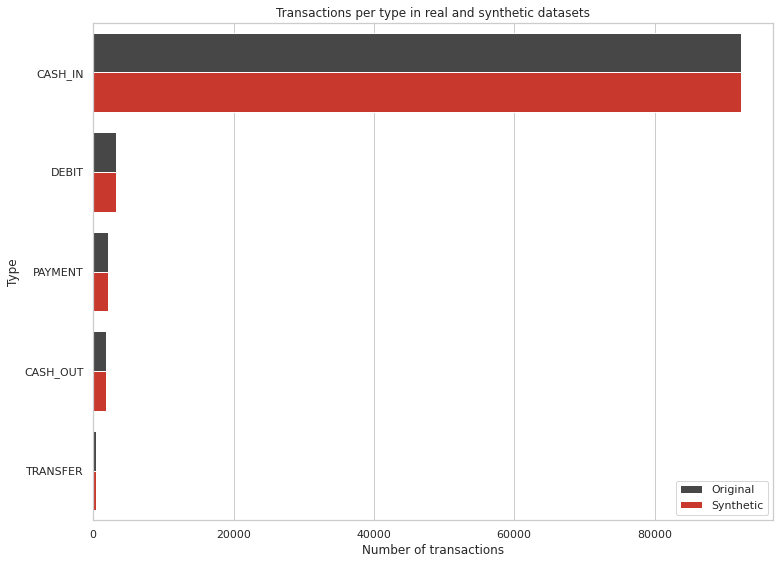

In [226]:
fig, ax = plt.subplots(figsize=[11, 8])
sns.barplot(data=ops_df, 
            y='Transaction', 
            x='Count', 
            hue='Data', 
            orient='h',
            ax=ax, 
            palette=[YDATA_COLOR_ALT, YDATA_COLOR], 
            alpha=1.0,
            )
ax.set_title("Transactions per type in real and synthetic datasets")
ax.set_xlabel("Number of transactions")
ax.set_ylabel("Type")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

**Number of unique origin entities (customers)**

As the only origin entity we have is customers, we can just compare the number of unique origin entities between the two datasets.

In [230]:
len(original.nameOrig.unique())

16188

In [231]:
len(full_synth.nameOrig.unique())

14592

**Number of unique destination entities (customers, merchants, banks)**

For destination entities (which can be _Customers_, _Merchants_ or _Banks_), we need to visualize:

In [244]:
original_banks = len(original[original.nameDest.str[0] == 'B'].nameDest.unique())
original_customers = len(original[original.nameDest.str[0] == 'C'].nameDest.unique())
original_merchants = len(original[original.nameDest.str[0] == 'M'].nameDest.unique())
synth_banks = len(full_synth[full_synth.nameDest.str[0] == 'B'].nameDest.unique())
synth_customers = len(full_synth[full_synth.nameDest.str[0] == 'C'].nameDest.unique())
synth_merchants = len(full_synth[full_synth.nameDest.str[0] == 'M'].nameDest.unique())

dest_data = {
    'Data': 3 * ['Original'] + 3 * ['Synthetic'] ,
    'Entity': ['Banks', 'Customers', 'Merchants'] * 2,
    'Count': [original_banks, original_customers, original_merchants, synth_banks, synth_customers, synth_merchants] 
}

dest_df = pd.DataFrame(dest_data)

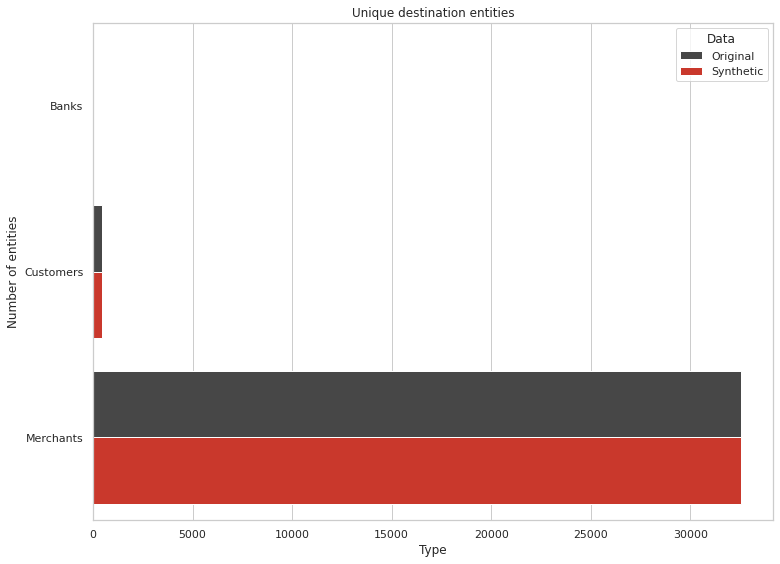

In [258]:
fig, ax = plt.subplots(figsize=[11, 8])
sns.barplot(data=dest_df, 
            y='Entity', 
            x='Count', 
            hue='Data', 
            orient='h',
            ax=ax, 
            palette=[YDATA_COLOR_ALT, YDATA_COLOR], 
            alpha=1.0,
            )
ax.set_title("Unique destination entities")
ax.set_xlabel("Type")
ax.set_ylabel("Number of entities")
#plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

**⚠️ TODO: Review, does this make sense?**

**Fraudulent events**

In [270]:
original_fraud = original[original.isFraud == 1].action.value_counts()
synth_fraud = full_synth[original.isFraud==1].action.value_counts()

fraud_data = {
    'Data': len(original_fraud) * ['Original'] + len(synth_fraud) * ['Synthetic'],
    'Type': original_fraud.index.tolist() + synth_fraud.index.tolist(),
    'Count': list(original_fraud.values) + list(synth_fraud.values)
}
fraud_df = pd.DataFrame(fraud_data)

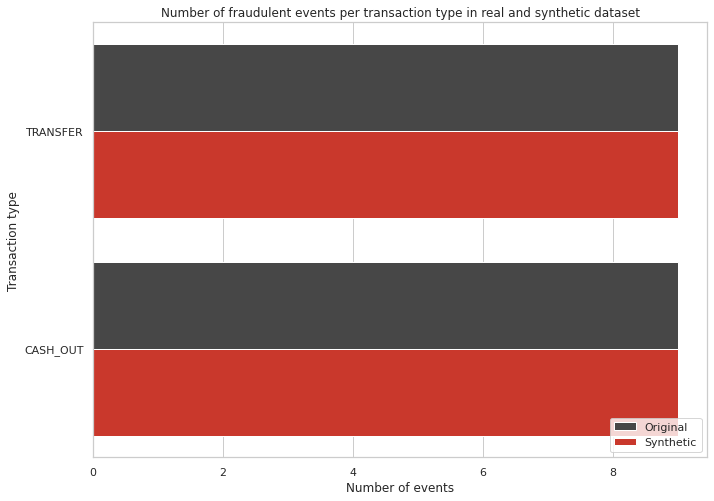

In [274]:
fig, ax = plt.subplots(figsize=[11, 8])
sns.barplot(data=fraud_df, 
            y='Type', 
            x='Count', 
            hue='Data', 
            orient='h',
            ax=ax, 
            palette=[YDATA_COLOR_ALT, YDATA_COLOR], 
            alpha=1.0,
            )
ax.set_title("Number of fraudulent events per transaction type in real and synthetic dataset")
ax.set_xlabel("Number of events")
ax.set_ylabel("Transaction type")
plt.legend(loc='lower right')
#plt.tight_layout()
plt.show()

**Unauthorized overdraft**

In [275]:
original_over = original[original.isUnauthorizedOverdraft == 1].action.value_counts()
synth_over = full_synth[original.isUnauthorizedOverdraft==1].action.value_counts()

over_data = {
    'Data': len(original_over) * ['Original'] + len(synth_over) * ['Synthetic'],
    'Type': original_over.index.tolist() + synth_over.index.tolist(),
    'Count': list(original_over.values) + list(synth_over.values)
}
over_df = pd.DataFrame(over_data)

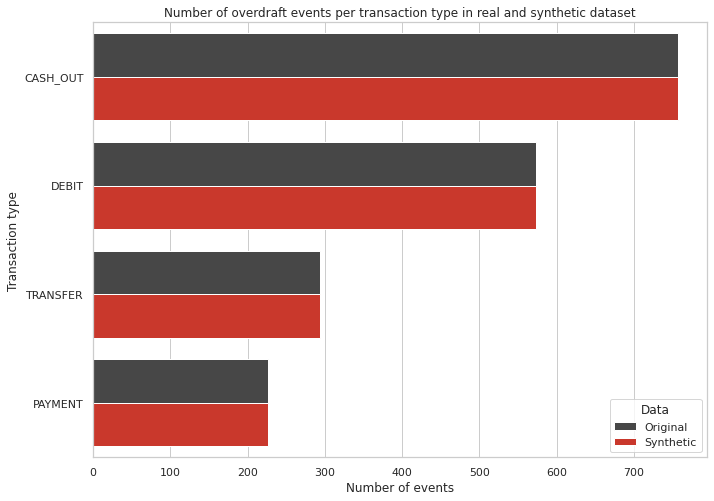

In [277]:
fig, ax = plt.subplots(figsize=[11, 8])
sns.barplot(data=over_df, 
            y='Type', 
            x='Count', 
            hue='Data', 
            orient='h',
            ax=ax, 
            palette=[YDATA_COLOR_ALT, YDATA_COLOR], 
            alpha=1.0,
            )
ax.set_title("Number of overdraft events per transaction type in real and synthetic dataset")
ax.set_xlabel("Number of events")
ax.set_ylabel("Transaction type")
#plt.legend(loc='lower right')
#plt.tight_layout()
plt.show()

**Distribution of balances (origin entities)**

**Distribution of balances (destination entities)**

**Evolution over time of the transactions'`amount`**

**Entity-specific trajectories of the balances**

**⚠️ TODO: Re-use constraints engine**

## Wrap-up

_Balance is a hidden state with deterministic rules and constraints (balance depends on previous row) - if that fails, so does the synthesis._